In [1]:
import sys
!python --version
import numpy as np
import xarray as xr
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import sklearn

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

Python 3.5.1
24 CPUs
numpy version: 1.11.0
xarray version: 0.11.3
matplotlib version: 1.4.3
sklearn version: 0.17.1


## Experiment 1

#### North America regional average, 8 variables, CMIP5-rcp26

Shallow embeddings via DTW affinities

In [10]:
ds = xr.open_dataset('data/models_all_vars_vs_time.nc')
X_ds = ds.to_array().transpose('models', 'time', 'variable')
D_x = np.load('data/dtw.npy')
D2_x = D_x**2.0
print(X_ds)

<xarray.DataArray (models: 40, time: 2880, variable: 6)>
array([[[ -1.232390e+00,  -8.221712e-01, ...,  -1.762584e-07,  -3.691904e-07],
        [ -9.980754e-01,  -3.134700e+00, ...,  -3.496395e-06,   2.935993e-07],
        ..., 
        [  1.093070e+00,   9.386808e-01, ...,  -3.006784e-06,   2.310148e-06],
        [  1.049638e+00,   1.553081e+00, ...,   5.685991e-06,   2.558547e-06]],

       [[ -6.226550e-01,  -2.455808e-01, ...,   1.469825e-06,   5.744220e-07],
        [ -8.767850e-01,   5.197417e-01, ...,  -7.336508e-06,  -3.874350e-08],
        ..., 
        [  9.840863e-01,   1.147870e+00, ...,  -1.667757e-06,   2.476872e-07],
        [  3.382746e-01,   7.926292e-01, ...,  -5.932489e-06,   3.007603e-06]],

       ..., 
       [[ -1.374901e+00,  -1.929253e+00, ...,   1.195963e-05,  -6.273888e-06],
        [ -5.095788e-01,  -3.281883e+00, ...,   7.633096e-06,   1.095362e-06],
        ..., 
        [  4.450033e-01,   8.567608e-01, ...,  -1.969318e-06,   2.737182e-06],
        [  5.74

In [11]:
all_models = X_ds.coords['models'].values
model_groups = dict()
for i, model in enumerate(all_models):
    pts = model.split('_')
    group_name, member_id = "".join(pts[:-1]), pts[-1]
    if group_name not in model_groups:
        model_groups[group_name] = []
    model_groups[group_name].append(i)

In [12]:
%matplotlib inline
def plot_model_embedding(X_emb, title=''):
    plt.figure(figsize=(8,6))
    cmap = cm.get_cmap('spectral_r')
    colors = [cmap(x) for x in np.linspace(0, 1, len(model_groups))]
    markers = ['o','s','D','v','^']
    for i, (name, inds) in enumerate(model_groups.items()):
        plt.scatter(X_emb[inds,0], X_emb[inds,1], s=36, marker=markers[i % len(markers)], c=colors[i], label=name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
    plt.title(title)
    plt.show()

/curc/sw/python/3.5.1/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


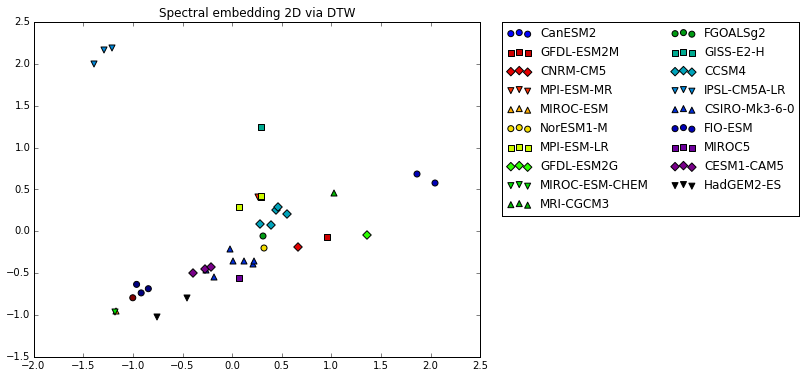

In [5]:
from sklearn.manifold import SpectralEmbedding

# compute affinity matrix from DTW distances
W = np.zeros(D_x.shape)
eps = 1.0
t = 1.0
for i, row in enumerate(W):
    for j, _ in enumerate(row):
        d = D_x[i,j]
        W[i,j] = np.exp(-d**2 / t) if i != j and d < eps else 0.0
        
# compute spectral embedding and plot
spectral = SpectralEmbedding(affinity='precomputed')
D_spec = spectral.fit_transform(W)
plot_model_embedding(D_spec, "Spectral embedding 2D via DTW")

/curc/sw/python/3.5.1/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


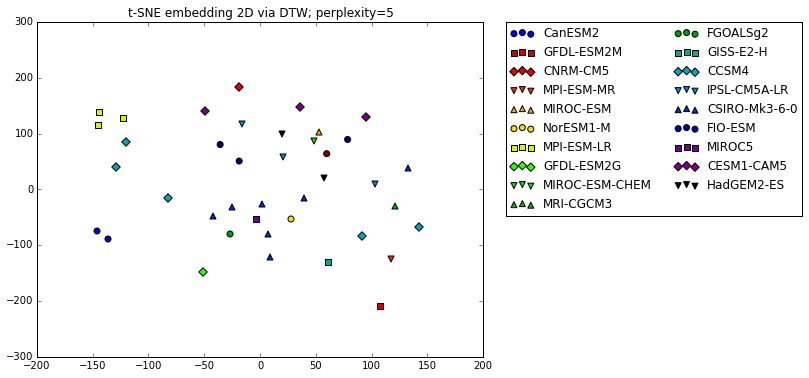

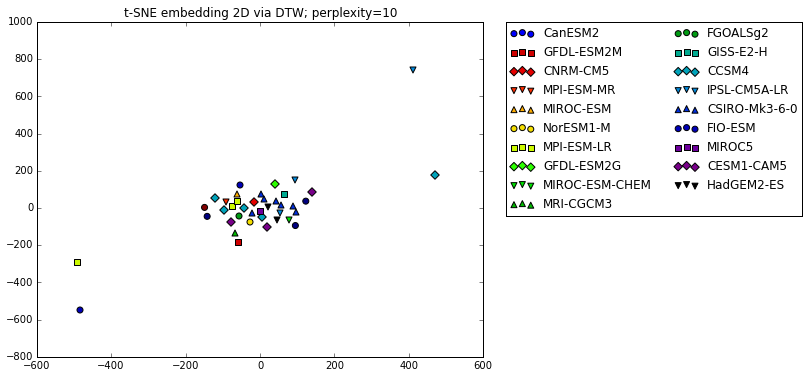

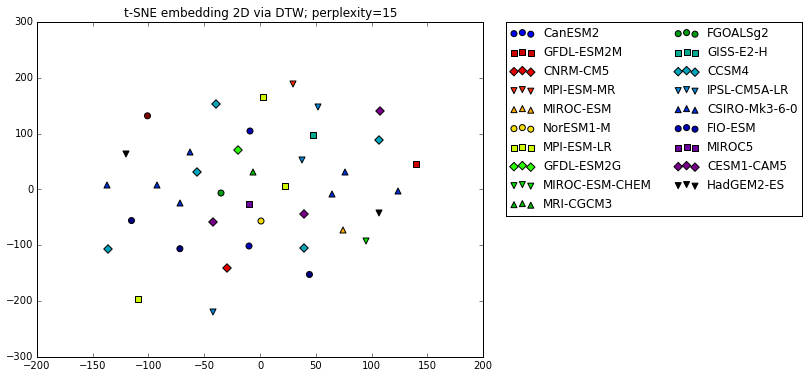

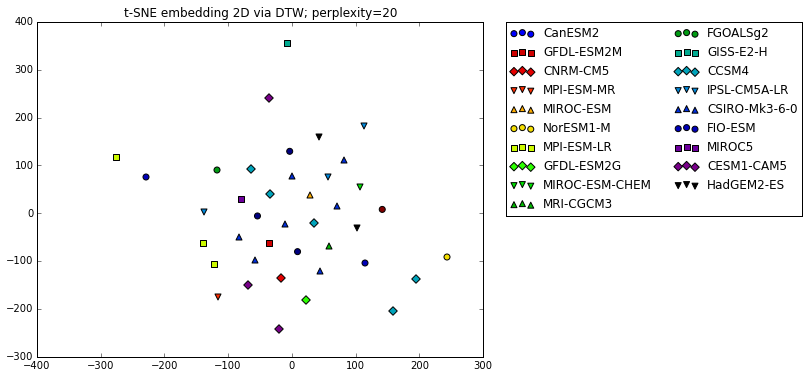

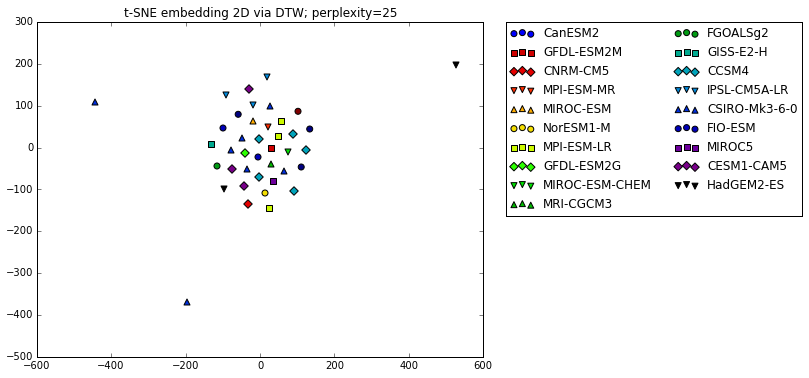

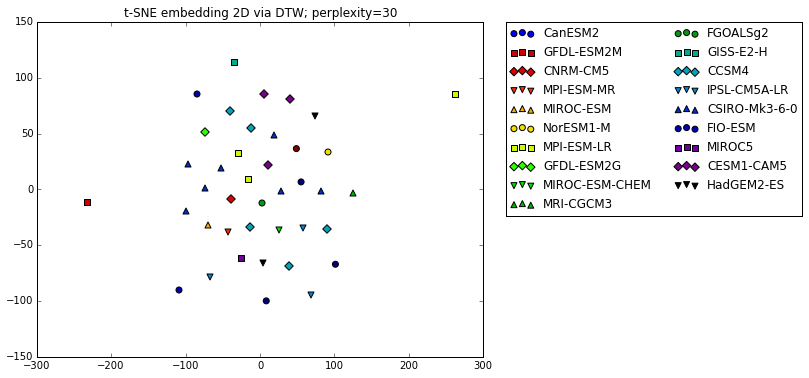

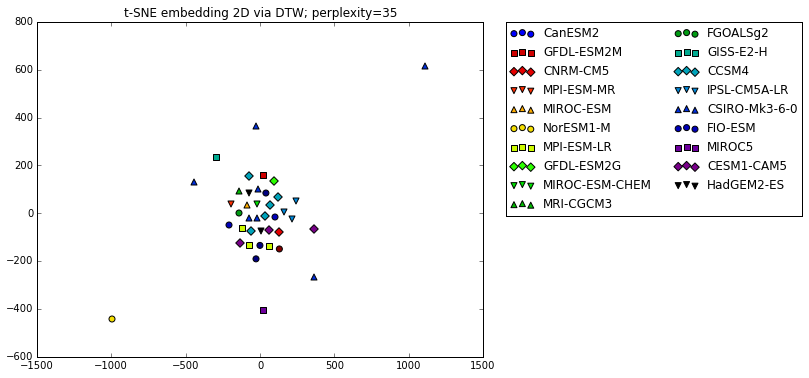

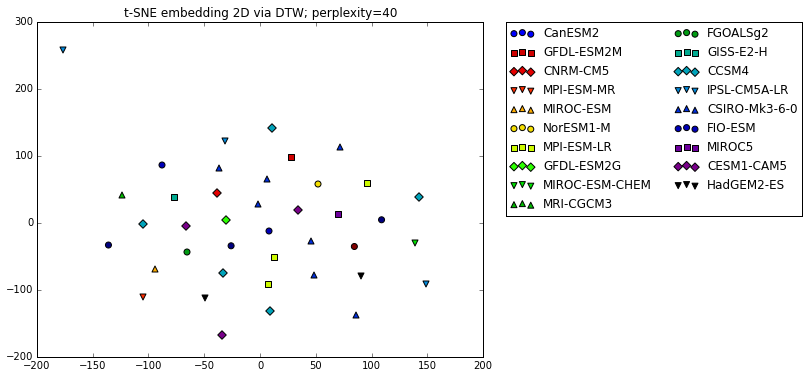

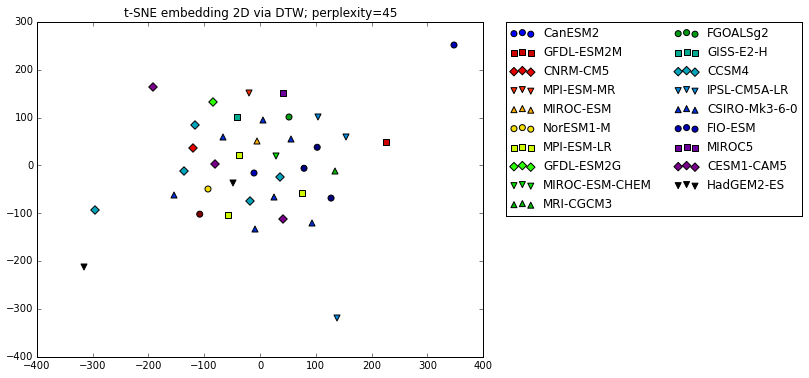

In [6]:
from sklearn.manifold import TSNE

perplexities = np.arange(5, 50, 5)
N_iter = 10
for p in perplexities:
    tsne = TSNE(perplexity=p, metric='precomputed')
    D_tsne = tsne.fit_transform(D_x)
    plot_model_embedding(D_tsne, "t-SNE embedding 2D via DTW; perplexity={}".format(p))

KeyError: "Does not support option: 'fastmath'"